<a href="https://colab.research.google.com/github/ua-datalab/Geospatial_Workshops/blob/main/notebooks/COGs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## This python notebook demonstrates the use of Cloud Optimized Geotiffs (COGs). It will show you how to stream a COG from cloud storage into a jupyter notebook and how to stream just a subset of the COG.

Jeffrey Gillan, Data Science Institute, University of Arizona, 2024



In [3]:
##Install library to work with raster images

!pip install rasterio --quiet
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 27.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 23.1 MB/s eta 0:00:0000:0100:01


In [4]:
#Bring libraries into the environment

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import requests
import numpy as np

In [5]:
# Define the url to the Cloud-Optimized Geotiff (COG). It is located in Cyverse Cloud Storage
cog_path = 'https://data.cyverse.org/dav-anon/iplant/home/jgillan/cog_test/planet_6sept2020_COG.tif'

In [6]:
##Get some basic information about the COG

with rasterio.open(cog_path) as dataset:
    # Now you can work with the dataset, e.g., read out specific bands, metadata, etc.
    print(dataset.profile)  # Print the dataset profile, like CRS, bounds, etc.

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 18828, 'height': 15837, 'count': 4, 'crs': CRS.from_epsg(32612), 'transform': Affine(3.0, 0.0, 488817.0,
       0.0, -3.0, 3613986.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


In [7]:
##Retrieve the file size of the COG

# Send an HTTP HEAD request
response = requests.head(cog_path)

if response.status_code == 200:
    # Check if 'Content-Length' header is available
    if 'Content-Length' in response.headers:
        file_size_bytes = int(response.headers['Content-Length'])
        print(f"File Size: {file_size_bytes} bytes")
    else:
        print("Content-Length header is not available.")
else:
    print(f"Failed to access the file. Status code: {response.status_code}")

File Size: 2192888505 bytes


In [8]:
# Is it a COG?

with rasterio.open(cog_path) as src:
    # Check for internal tiling
    tiled = src.is_tiled
    print(f"Tiled: {tiled}")

    # Check for overviews
    overviews = src.overviews(1)  # Checks overviews for the first band
    has_overviews = len(overviews) > 0
    print(f"Has Overviews: {has_overviews}")

Tiled: True
Has Overviews: True


In [10]:
# Perform a GET request to download the COG to the Colab disk (this is temporary!)
response = requests.get(cog_path)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Open the local file in binary write mode and save the content of the COG
    with open('cog_example.tif', 'wb') as f:
        f.write(response.content)
    print("COG downloaded successfully.")
else:
    print(f"Failed to download COG. Status code: {response.status_code}")

COG downloaded successfully.


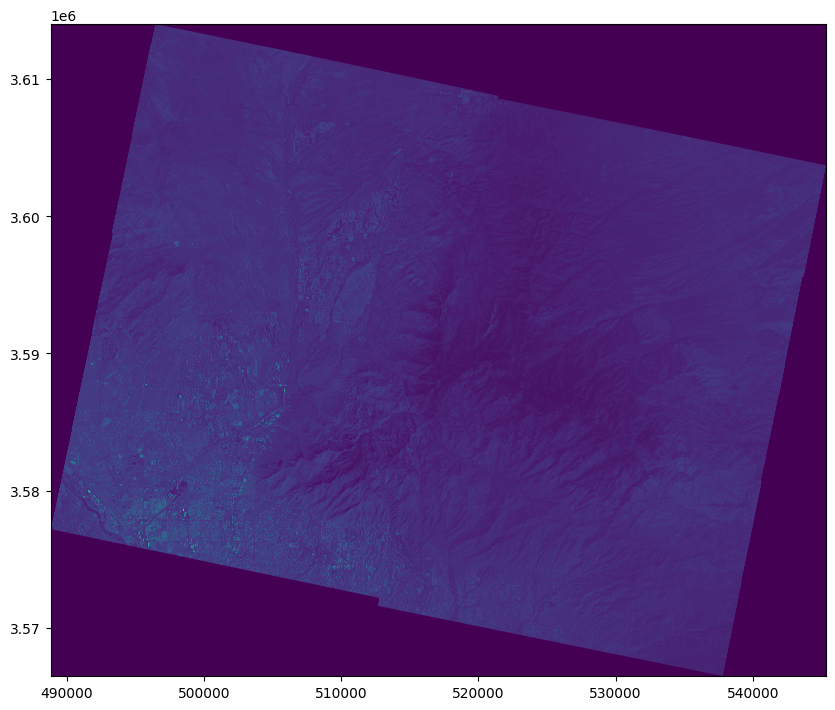

In [12]:
##Read in and display the entire COG. Large files require a lot of memory usage.

with rasterio.open(cog_path) as dataset:
    # Read the entire dataset
    # This reads all bands; if the dataset is multi-band, they will be read into a 3D array
    data = dataset.read()

    # Display the image
    # For simplicity, this example displays the first band.
    plt.figure(figsize=(10, 10))
    show(data[0], transform=dataset.transform)

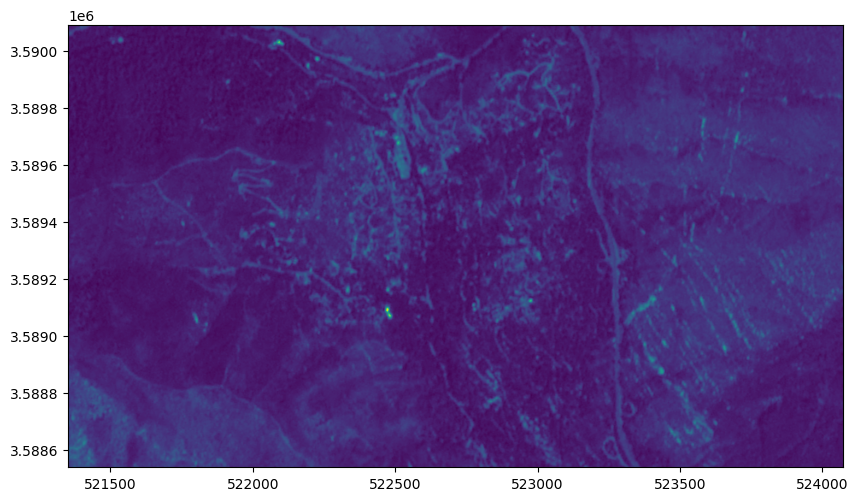

CRS: EPSG:32612
Width: 907, Height: 518
Data Type: uint16


In [13]:
##Bring in and display a subset of the COG. This should require less memory than the full image.


# Create a subset (aka window) bounding box. Make sure to match the Coordinate Reference System of the data. Here we use UTM coordinates.
utm_x1, utm_y1 = 521354, 3588540   # Lower left corner
utm_x2, utm_y2 = 524074, 3590092   # Upper right corner


with rasterio.open(cog_path) as dataset:
    # Convert UTM coordinates to pixel coordinates
    # Note: This assumes the dataset is in a UTM projection
    px1, py1 = dataset.index(utm_x1, utm_y1)
    px2, py2 = dataset.index(utm_x2, utm_y2)

    # Create a window from the pixel coordinates
    # Note: min/max functions ensure the coordinates are ordered correctly
    window = rasterio.windows.Window.from_slices((min(px1, px2), max(px1, px2)), (min(py1, py2), max(py1, py2)))

    # Read the data within the window
    subset = dataset.read(window=window)

    # Display the image showing band 1
    plt.figure(figsize=(10, 10))
    show(subset[0], transform=dataset.window_transform(window))

    print(f"CRS: {dataset.crs}")
    print(f"Width: {window.width}, Height: {window.height}")
    print(f"Data Type: {dataset.dtypes[0]}")

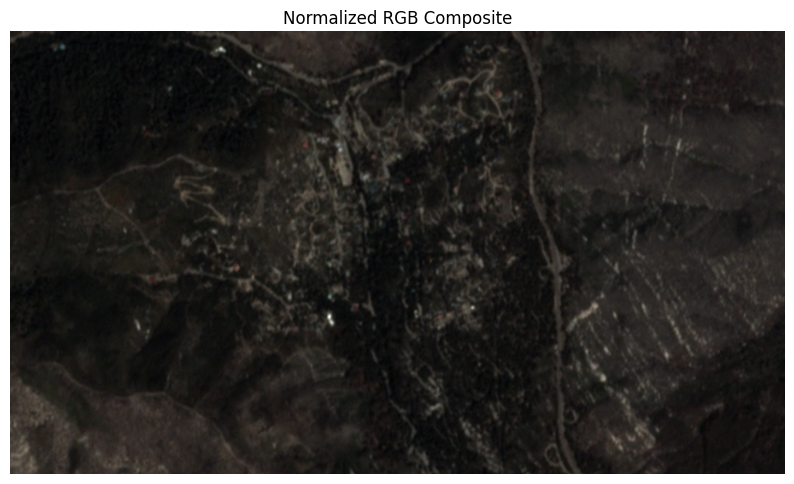

CRS: EPSG:32612
Width: 907, Height: 518
Data Type: uint16


In [14]:
#Display the COG subset multi-band image

# Function to normalize the bands
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Create a subset (aka window) bounding box. Make sure to match the CRS of the data. Here we use UTM coordinates.
utm_x1, utm_y1 = 521354, 3588540   # Lower left corner
utm_x2, utm_y2 = 524074, 3590092   # Upper right corner

with rasterio.open(cog_path) as dataset:
    # Convert UTM coordinates to pixel coordinates
    px1, py1 = dataset.index(utm_x1, utm_y1)
    px2, py2 = dataset.index(utm_x2, utm_y2)

    # Create a window from the pixel coordinates
    window = rasterio.windows.Window.from_slices((min(px1, px2), max(px1, px2)), (min(py1, py2), max(py1, py2)))

    # Read red, green, blue bands to make an RGB composite
    rgb_bands = dataset.read([3, 2, 1], window=window)

    # Normalize each band
    rgb_normalized = np.zeros(rgb_bands.shape, dtype=np.float32)
    for band in range(rgb_bands.shape[0]):
        rgb_normalized[band] = normalize(rgb_bands[band])

    # Transpose the array to get it into (height, width, bands) shape
    rgb_normalized = np.transpose(rgb_normalized, axes=(1, 2, 0))

    # Display the RGB image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_normalized)
    plt.title('Normalized RGB Composite')
    plt.axis('off')  # Remove axis ticks and labels
    plt.show()

    print(f"CRS: {dataset.crs}")
    print(f"Width: {window.width}, Height: {window.height}")
    print(f"Data Type: {dataset.dtypes[0]}")

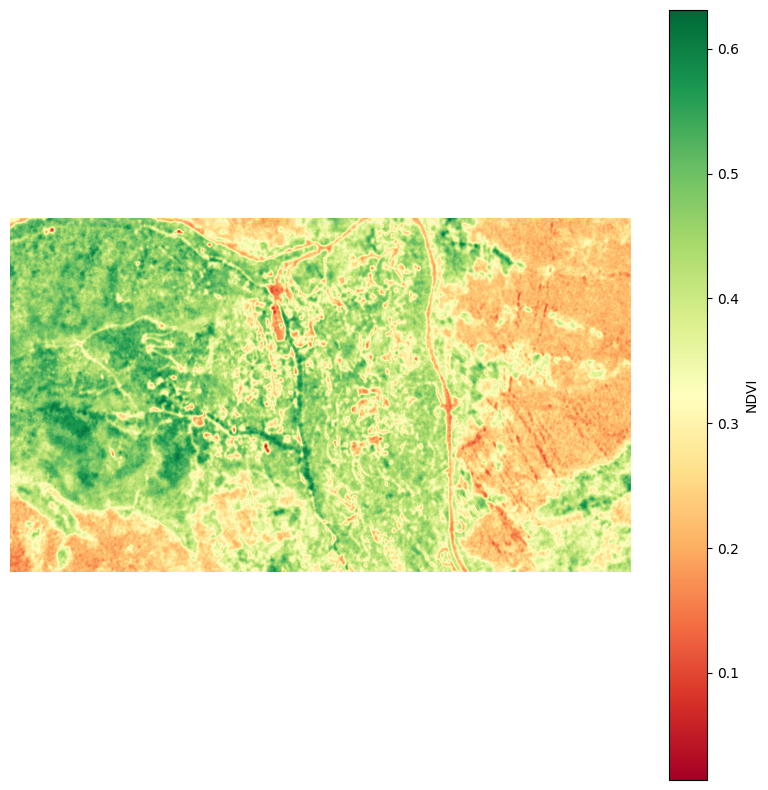

In [15]:
## Calculate an NDVI on the satellite imagery for just the subset

# Assuming 'data' is a numpy array with shape (4, height, width)
# where the bands are ordered as (Blue, Green, Red, NIR)

# Extract the Red and NIR bands
red = subset[2, :, :]  # Assuming the third band is Red
nir = subset[3, :, :]  # Assuming the fourth band is NIR

# Calculate NDVI
# Note: It's important to convert the bands to float to avoid integer overflow issues
# and ensure proper division
ndvi = (nir.astype(float) - red.astype(float)) / (nir + red + 1e-10)  # 1e-10 to avoid division by zero

# Display the NDVI
plt.figure(figsize=(10, 10))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.axis('off')  # Optional: removes the axis and labels
plt.show()